# Resampling DES Y1

The DES Y1 3x2pt analysis is a tricky beast because it has SO many parameters (26). Samplers don't know the marginal likelihoods of only the interesting parameters (cosmology), and only ever report the joint posterior of all parameters given the data. For this reason, if we want to resample the DES Y1 chain, we have to traing the Gaussian processes on all parameters in the chain.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
input_chain = np.loadtxt("DES_LCDM_allparams.txt")[-10000:]
lnpost = np.loadtxt("DES_LCDM_lnpost.txt")[-10000:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)

('chain shape is  ', (10000, 26))
('lnpost shape is ', (10000,))


In [4]:
#Pick out training points
N_training = 300
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

In [5]:
#Train the GP inside of the sampler
IS.train()

      fun: 814884.3680449151
 hess_inv: array([[2.16607629e-10]])
      jac: array([5.04952041e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 3
     njev: 75
   status: 2
  success: False
        x: array([3.61064381])


In [6]:
#Resample the chain with an MCMC
means = np.mean(input_chain, 0)

nwalkers = 200
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)

print("Running first burn-in")
p0 = np.array([means + means*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 3000);

Running first burn-in
Running second burn-in
Running production...


In [7]:
test_chain = sampler.flatchain
print("Means and stds of input chain: ", np.mean(input_chain, 0)[:4], np.std(input_chain, 0)[:4])
print("Means and stds of test chain:  ", np.mean(test_chain, 0)[:4], np.std(test_chain, 0)[:4])

('Means and stds of input chain: ', array([0.29176361, 0.74090343, 0.05235583, 0.98883199]), array([0.04303474, 0.08860382, 0.01003007, 0.05218202]))
('Means and stds of test chain:  ', array([0.28252077, 0.82710289, 0.04619714, 0.98267902]), array([0.01548544, 0.0332239 , 0.00471024, 0.02178965]))


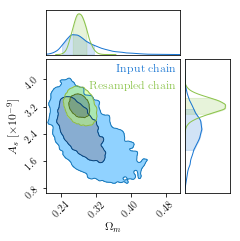

In [8]:
c = CC.ChainConsumer()

plot_input_chain = [input_chain[:,0], input_chain[:,4]]
plot_test_chain = [test_chain[:,0], test_chain[:,4]]

labels = [r"$\Omega_m$", r"$h$", r"$\Omega_b$", r"$n_s$", r"$A_s$"]
labels = [r"$\Omega_m$", r"$A_s$"]

c.add_chain(plot_input_chain, parameters=labels, name="Input chain")
c.add_chain(plot_test_chain, parameters=labels, name="Resampled chain")

fig = c.plotter.plot()
#fig.savefig("DESY1_resampling_example.png", dpi=300, bbox_inches="tight")